In [1]:
import math
from typing import List, Tuple, Dict
from pathlib import Path
from copy import deepcopy
import hashlib

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from stego import FloatBinary, str_to_bits, bits_to_str, dummy_data_generator

In [2]:
# How many bits (LSB) to use from the fraction (mantissa) of the float values
BITS_TO_USE = 16
assert BITS_TO_USE <= 23, "Can't be bigger then 23 bits"

# Load the model

In [3]:
model = tf.keras.applications.ResNet50(include_top=True, weights="imagenet")

In [4]:
layers_storage_capacity_mb: Dict[str, int] = {}

for l in model.layers:
    if l.__class__.__name__ == "Conv2D":
        nb_params = np.prod(l.get_weights()[0].shape)
        capacity_in_bytes = np.floor((nb_params * BITS_TO_USE) / 8).astype(int)
        layers_storage_capacity_mb[l.name] = capacity_in_bytes / float(1<<20)

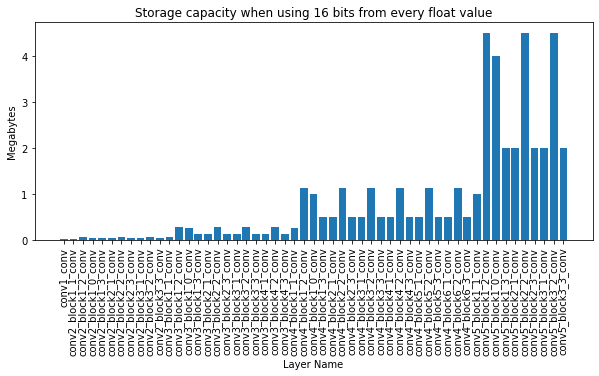

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
ax.bar(layers_storage_capacity_mb.keys(), layers_storage_capacity_mb.values())
ax.tick_params(axis='x', labelrotation = 90)
ax.set_xlabel("Layer Name")
ax.set_ylabel("Megabytes")
ax.set_title(f"Storage capacity when using {BITS_TO_USE} bits from every float value");

# Inspect statistics for selected layers

In [6]:
# Layers with the most storage capacity
sorted(layers_storage_capacity_mb.items(), key=lambda x: x[1], reverse=True)[:5]

[('conv5_block1_2_conv', 4.5),
 ('conv5_block2_2_conv', 4.5),
 ('conv5_block3_2_conv', 4.5),
 ('conv5_block1_0_conv', 4.0),
 ('conv5_block1_3_conv', 2.0)]

In [7]:
layer_names = ["conv5_block1_2_conv", "conv5_block2_2_conv", "conv5_block3_2_conv"]

In [8]:
selected_layers_weights = []
for n in layer_names:
    v = model.get_layer(n).weights[0].numpy().ravel()
    selected_layers_weights.extend(v)
selected_layers_weights = np.array(selected_layers_weights)

## Basic statistics

In [9]:
nb_values = len(selected_layers_weights)
min_value = selected_layers_weights.min()
abs_min_value = np.abs(selected_layers_weights).min()
max_value = selected_layers_weights.max()
mean_value = selected_layers_weights.mean()
nb_really_small_values = (abs(selected_layers_weights) < 10e-4).sum()
nb_small_values = (abs(selected_layers_weights) < 10e-3).sum()
nb_negative_values = (selected_layers_weights < 0).sum()
nb_positive_values = (selected_layers_weights > 0).sum()
overall_storage_capacity_bytes = nb_values * BITS_TO_USE / 8
overall_storage_capacity_mb = overall_storage_capacity_bytes // float(1<<20)

In [10]:
print(f"""Stats for {layer_names}
---
Min: {min_value}
Abs. Min {abs_min_value}
Max: {max_value}
Mean: {mean_value}
---
Nb total values: {nb_values}
Nb values < 10e-4: {nb_really_small_values} - {nb_really_small_values/nb_values*100:.4f}%
Nb values < 10e-3: {nb_small_values} - {nb_small_values/nb_values*100:.4f}%
Nb negatives: {nb_negative_values} - {nb_negative_values/nb_values*100:.4f}%
Nb positives: {nb_positive_values} - {nb_positive_values/nb_values*100:.4f}%
---
(Maximum) Storage capacity is {overall_storage_capacity_mb} MB for the {len(layer_names)} layers
""")

Stats for ['conv5_block1_2_conv', 'conv5_block2_2_conv', 'conv5_block3_2_conv']
---
Min: -0.21694281697273254
Abs. Min 1.157992812750308e-09
Max: 0.28386327624320984
Mean: -0.0009956692811101675
---
Nb total values: 7077888
Nb values < 10e-4: 521339 - 7.3657%
Nb values < 10e-3: 4550559 - 64.2926%
Nb negatives: 3914895 - 55.3116%
Nb positives: 3162993 - 44.6884%
---
(Maximum) Storage capacity is 13.0 MB for the 3 layers



# Hide a secret in the layer

## The secret

In [11]:
# secret_to_hide = "I am Gabor and I would like to hide this message"
secret_to_hide = dummy_data_generator.generate_dummy_data(overall_storage_capacity_bytes)
secret_bits = str_to_bits(secret_to_hide)

In [12]:
nb_vals_needed = math.ceil(len(secret_bits) / BITS_TO_USE)

In [13]:
print(f"We need {nb_vals_needed} float values to store the info. Number of values {nb_values}")

We need 7077888 float values to store the info. Number of values 7077888


## Hide it

In [14]:
# This dict holds the original weights for the selected layers
original_weights_dict: dict = {}
for n in layer_names:
    original_weights_dict[n] = deepcopy(model.get_layer(n).weights[0].numpy())

In [15]:
# This dict will hold the modified (secret hidden) weights for the layers
modified_weights_dict = deepcopy(original_weights_dict)
# Index of the last value used in a layer - this is needed because we don't necessary need
# the same number of params for hiding some bits then all the layer parameters
last_index_used_in_layer_dict: dict = {}

# We are modifying the layers in a defined order to know what was changed exactly
# This order is needed when we would like to recover the message

i = 0

for n in layer_names:
    w = modified_weights_dict[n]
    w_shape = w.shape
    w = w.ravel()
    
    nb_params_in_layer: int = np.prod(w.shape)
    
    for j in range(nb_params_in_layer):
        # Chunk of data from the secret to hide
        _from_index = i * BITS_TO_USE
        _to_index = _from_index + BITS_TO_USE
        bits_to_hide = secret_bits[_from_index:_to_index]
        bits_to_hide = list(map(bool, bits_to_hide))
        
        # Modify the defined bits of the float value fraction
        x = FloatBinary(w[j])
        fraction_modified = list(x.fraction)
        fraction_modified[-BITS_TO_USE:] = bits_to_hide
        x_modified = x.modify_clone(fraction=tuple(fraction_modified))
        w[j] = x_modified.v
        
        i += 1
    
    last_index_used_in_layer_dict[n] = j
    w = w.reshape(w_shape)
    modified_weights_dict[n] = w
    
    print(f"Layer {n} is processed, last index modified: {j}")

Layer conv5_block1_2_conv is processed, last index modified: 2359295
Layer conv5_block2_2_conv is processed, last index modified: 2359295
Layer conv5_block3_2_conv is processed, last index modified: 2359295


In [16]:
last_index_used_in_layer_dict

{'conv5_block1_2_conv': 2359295,
 'conv5_block2_2_conv': 2359295,
 'conv5_block3_2_conv': 2359295}

# Let's test the network

## Dataset to test on

In [17]:
image_paths = list(map(str, Path("/Users/gabor.vecsei/Documents/test_images").glob("**/*.jpeg")))

In [18]:
len(image_paths)

566

In [19]:
batch_size = 1

In [20]:
def _read_image_from_path(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_image(image, channels=3, dtype=tf.uint8, expand_animations=False)
    image = tf.image.resize(image, (224, 224))
    return image

dataset = tf.data.Dataset.from_tensor_slices(image_paths)
dataset = dataset.map(_read_image_from_path, num_parallel_calls=tf.data.AUTOTUNE)
dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

## Predictions

### Original weights predictions

In [21]:
for n in layer_names:
    w = original_weights_dict[n]
    model.get_layer(n).set_weights([w, model.get_layer(n).get_weights()[1]])

In [22]:
preds_original = model.predict(dataset)

### Modified weights predictions

In [23]:
for n in layer_names:
    w = modified_weights_dict[n]
    model.get_layer(n).set_weights([w, model.get_layer(n).get_weights()[1]])

In [24]:
preds_modified = model.predict(dataset)

## Differences in predictions

### Raw prediction value comparisons (last layer output)

In [25]:
diff_abs = np.abs(preds_original - preds_modified).ravel()

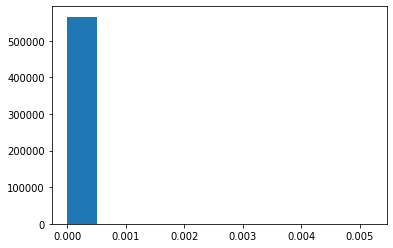

In [26]:
plt.hist(diff_abs[diff_abs > 0]);

In [27]:
print(f"Min abs difference: {diff_abs.min()}")
print(f"Max abs difference: {diff_abs.max()}")
print(f"Number of changed prediction values: {(diff_abs > 0).sum()} / {len(diff_abs)} | {(diff_abs > 0).sum()/len(diff_abs)*100:.4f}%")

Min abs difference: 0.0
Max abs difference: 0.005199462175369263
Number of changed prediction values: 565996 / 566000 | 99.9993%


### Change in predicted labels

In [28]:
nb_changed_pred_labels = ((np.argmax(preds_original, 0) - np.argmax(preds_modified, 0)) > 0).sum()

In [29]:
print(f"Changed number of predictions: {nb_changed_pred_labels} / {len(image_paths)} | {nb_changed_pred_labels/len(image_paths)*100}%")

Changed number of predictions: 0 / 566 | 0.0%


# Recover the secret

In [30]:
# We store the extracted bits of data here
hidden_data: List[bool] = []

for n in layer_names:
    # We could get the modified weights directly from the model: model.get_layer(n).get_weights()...
    w = modified_weights_dict[n]
    w_shape = w.shape
    w = w.ravel()
    
    nb_params_in_layer: int = np.prod(w.shape)
    
    for i in range(last_index_used_in_layer_dict[n]+1):
        x = FloatBinary(w[i])
        hidden_bits = x.fraction[-BITS_TO_USE:]
        hidden_data.extend(hidden_bits)
        
    print(f"Layer {n} is processed, bits are extracted")

Layer conv5_block1_2_conv is processed, bits are extracted
Layer conv5_block2_2_conv is processed, bits are extracted
Layer conv5_block3_2_conv is processed, bits are extracted


In [31]:
recovered_message: str = bits_to_str(list(map(int, hidden_data)))

In [32]:
chars_to_display = 100
print(f"--Original string:--\n'{secret_to_hide[:chars_to_display]}...'")
print(f"--Recovered string:--\n'{recovered_message[:chars_to_display]}...'")

--Original string:--
'.A*'F{KyoL=e8>V359-3b"OlzXJMUT6>z~k[V*'#:leLXt8VGqr:Ub?VB?NFp_^^3gP_}M[bta
Z!p(9NGYvuS!-B>O`0.|,g...'
--Recovered string:--
'.A*'F{KyoL=e8>V359-3b"OlzXJMUT6>z~k[V*'#:leLXt8VGqr:Ub?VB?NFp_^^3gP_}M[bta
Z!p(9NGYvuS!-B>O`0.|,g...'


In [33]:
def hash_str(s: str) -> str:
    return hashlib.md5(s.encode("ascii")).hexdigest()

In [34]:
assert hash_str(recovered_message) == hash_str(secret_to_hide), "Recovered message hash is not the same as the original one"

In [35]:
assert recovered_message == secret_to_hide, "Recovered message is not the same as the original one"